In [5]:
import os
import numpy as np
import pandas as pd
import cv2
import sys
import collections

from glob import glob
from os import path
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

%matplotlib inline

In [6]:
# Id represent classes

"""
['6': 'pants', '0': 'shirt, blouse', '28' : 'collar', '31': 'sleeve', '32' : 'pocket', '29':'lapel', 
 '4': 'jacket', '33':'straight', '1':'top, t-shirt, sweatshirt', '10':'dress', '23':'shoe', '15':'headband, head covering, hair accessory',
'13':'glasses', '8':'skirt', '35':'zipper', '24':'bag, wallet', '19':'belt', '3': 'cardigan', '7':'shorts', 
 '37': 'bead', '36':'applique', '22':'sock', '14':'hat',
'18':'watch', '17':'glove', '21':'tights, stockings', '34':'buckle', '42':'rivet', '9':'coat', 
 '2':'sweater', '16':'tie', '39':'flower', '25':'scarf', '43':'ruffle',
'40':'fringe', '44':'sequin', '27':'hood', '5':'vest', '38':'high low', '41':'regular (fit)', 
 '30':'bootcut', '26':'mermaid', '12':'lace up', '11':'double breasted', '20':'symmetrical',
'45':'distressed']
"""

"\n['6': 'pants', '0': 'shirt, blouse', '28' : 'collar', '31': 'sleeve', '32' : 'pocket', '29':'lapel', \n '4': 'jacket', '33':'straight', '1':'top, t-shirt, sweatshirt', '10':'dress', '23':'shoe', '15':'headband, head covering, hair accessory',\n'13':'glasses', '8':'skirt', '35':'zipper', '24':'bag, wallet', '19':'belt', '3': 'cardigan', '7':'shorts', \n '37': 'bead', '36':'applique', '22':'sock', '14':'hat',\n'18':'watch', '17':'glove', '21':'tights, stockings', '34':'buckle', '42':'rivet', '9':'coat', \n '2':'sweater', '16':'tie', '39':'flower', '25':'scarf', '43':'ruffle',\n'40':'fringe', '44':'sequin', '27':'hood', '5':'vest', '38':'high low', '41':'regular (fit)', \n '30':'bootcut', '26':'mermaid', '12':'lace up', '11':'double breasted', '20':'symmetrical',\n'45':'distressed']\n"

In [4]:
!pip install iglovikov_helper_functions

  Using cached iglovikov_helper_functions-0.0.53-py2.py3-none-any.whl (64 kB)
     |██▋                             | 1.1 MB 128 kB/s eta 0:01:34^C

ERROR: Operation cancelled by user
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
NUM_CLASSES = 46

In [8]:
root_path_train = './train/'
df_path_train = './train.csv'

In [22]:
def create_one_represent_class(df_param):
    v_c_df = df_param['CategoryId'].value_counts().reset_index()
    one_represent = v_c_df.loc[v_c_df['CategoryId'] == 1, 'index'].tolist()
    df_param.loc[df_param['CategoryId'].isin(one_represent), 'CategoryId'] = 'one_represent'
    return df_param

def custom_train_test_split(df_param):
    
    df_param['CategoryId'] = df_param.ClassId.apply(lambda x: str(x).split("_")[0])
    
    img_categ = train_df.groupby('ImageId')['CategoryId'].apply(list).reset_index()
    img_categ['CategoryId'] = img_categ['CategoryId'].apply(lambda x: ' '.join(sorted(x)))
    
    img_categ = create_one_represent_class(img_categ)
    
    img_train, img_val  = train_test_split(img_categ, test_size=0.2, random_state=42, stratify=img_categ['CategoryId'])
    
    df_param = df_param.drop(columns='CategoryId')
    
    df_train = df_param[df_param['ImageId'].isin(img_train['ImageId'])].reset_index(drop=True)
    df_val = df_param[df_param['ImageId'].isin(img_val['ImageId'])].reset_index(drop=True)
    
    return df_train, df_val

In [9]:
# read imaterial data 
train_df = pd.read_csv(df_path_train)
train_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


In [10]:
train_df.shape

(331213, 5)

In [11]:
(train_df.ImageId.unique()).shape

(45195,)

In [12]:
len(train_df['EncodedPixels'][0])

21303

In [13]:
train_df.ClassId.value_counts()

31                        58810
23                        46206
33                        33902
32                        27037
10                        15585
                          ...  
10_3_14_20_34_59_61_87        1
10_3_10_20_34_60_61_87        1
10_9_12_20_28_60_61_87        1
10_9_14_20_35_60_77_88        1
8_7_14_20_25_60_67_88         1
Name: ClassId, Length: 6354, dtype: int64

In [14]:
#split classId by underscore to get refined data and name it to categoryID
train_df['CategoryId'] = train_df.ClassId.apply(lambda x: str(x).split("_")[0])

In [15]:
train_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32


In [16]:
train_df['CategoryId'].value_counts().head()

31    58810
23    46206
33    33903
32    27037
10    18665
Name: CategoryId, dtype: int64

In [17]:
train_df['CategoryId'].unique()

array(['6', '0', '28', '31', '32', '29', '4', '33', '1', '10', '23', '15',
       '13', '8', '35', '24', '19', '3', '7', '37', '36', '22', '14',
       '18', '17', '21', '34', '42', '9', '2', '16', '39', '25', '43',
       '40', '44', '27', '5', '38', '41', '30', '26', '12', '11', '20',
       '45'], dtype=object)

In [18]:
#total category values / labels
train_df['CategoryId'].value_counts().shape

(46,)

In [19]:
train_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32


In [20]:
df = train_df[train_df['CategoryId'].isin(['0','1','2','4','3','9','28','31','32','27'])]

In [21]:
img_filtered = df.groupby('ImageId')['CategoryId'].apply(list).reset_index()

In [22]:
img_filtered.shape

(34242, 2)

In [23]:
#group images by labels/ class
img_categ = train_df.groupby('ImageId')['CategoryId'].apply(list).reset_index()

In [24]:
img_categ.head()

,ImageId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,"[6, 0, 28, 31, 32, 32, 31, 29, 4]"
1,0000fe7c9191fba733c8a69cfaf962b7.jpg,"[33, 1]"
2,0002ec21ddb8477e98b2cbb87ea2e269.jpg,"[33, 10, 23, 23]"
3,0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,"[10, 33, 15]"
4,0004467156e47b0eb6de4aa6479cbd15.jpg,"[10, 33, 31, 31, 15]"


In [25]:
#sort categoryId in columns 
img_categ['CategoryId'] = img_categ['CategoryId'].apply(lambda x: ' '.join(sorted(x)))

In [26]:
img_categ.head()

,ImageId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,0 28 29 31 31 32 32 4 6
1,0000fe7c9191fba733c8a69cfaf962b7.jpg,1 33
2,0002ec21ddb8477e98b2cbb87ea2e269.jpg,10 23 23 33
3,0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,10 15 33
4,0004467156e47b0eb6de4aa6479cbd15.jpg,10 15 31 31 33


In [31]:
#count number of images having same labels 
vcount_df = img_categ['CategoryId'].value_counts().reset_index()
vcount_df.shape

(18700, 2)

In [32]:
vcount_df.head()

,index,CategoryId
0,10 23 23 33,1841
1,10 33,1768
2,1 31 31 33,1095
3,10 23 23 31 31 33,818
4,10 31 31 33,800


In [33]:
#number of images which has count 1

vcount_df[vcount_df['CategoryId'] == 1]

,index,CategoryId
3388,27 31 31 32 32 35 35 4 6,1
3389,1 23 23 28 44 44 44 44 44 44 44 6,1
3390,1 14 23 23 27 28 30 30 31 31 32 32 32 32 32 33...,1
3391,10 2 24 28 31 31 32 32 7,1
3392,1 14 23 33 6,1
...,...,...
18695,1 18 19 31 31 32 32 33 34 42 6,1
18696,1 18 19 23 23 28 3 31 31 31 31 32 34 6,1
18697,13 14,1
18698,1 13 14 2 23 23 24 29 31 31 32 32 32 33 33 6 9,1


In [34]:
(vcount_df[vcount_df['CategoryId'] == 1]).shape

(15312, 2)

In [35]:
one_represent = vcount_df.loc[vcount_df['CategoryId'] == 1, 'index'].to_list()

In [36]:
#number of images having count 1 for labels 
len(one_represent)

15312

In [37]:
img_categ.loc[img_categ['CategoryId'].isin(one_represent), 'CategoryId'] = 'one_represent'

In [38]:
img_categ.head()

,ImageId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,0 28 29 31 31 32 32 4 6
1,0000fe7c9191fba733c8a69cfaf962b7.jpg,1 33
2,0002ec21ddb8477e98b2cbb87ea2e269.jpg,10 23 23 33
3,0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,10 15 33
4,0004467156e47b0eb6de4aa6479cbd15.jpg,10 15 31 31 33


In [44]:
img_categ['CategoryId']=='one_represent'

0        False
1        False
2        False
3        False
4        False
         ...  
45190    False
45191     True
45192    False
45193    False
45194    False
Name: CategoryId, Length: 45195, dtype: bool

In [39]:
train_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32


In [44]:
def rle_decode(mask_rle, shape):
    
    shape = (shape[1], shape[0])
    split_rle = mask_rle.split()
    # gets starts & lengths 1d arrays
    starts, lengths = [np.asarray(x, dtype=int) for x in (split_rle[0::2], split_rle[1::2])]
    starts -= 1
    # gets ends 1d array
    ends = starts + lengths
    # creates blank mask image 1d array
    image = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    # sets mark pixles
    for lo, hi in zip(starts, ends):
        image[lo:hi] = 1
    # reshape as a 2d mask image
    return image.reshape(shape).T  

    
class iMatDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, df, height, width, augmentation=None, preprocessing=None):
        
        self.preprocessing = preprocessing
        self.augmentation = augmentation
        
        self.image_dir = image_dir
        self.df = df
        
        self.height = height
        self.width = width
        
        self.image_info = collections.defaultdict(dict)
        
        self.df['CategoryId'] = self.df.ClassId.apply(lambda x: str(x).split("_")[0])
        self.num_classes = self.df['CategoryId'].nunique()
        
        temp_df = self.df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x)).reset_index()
        size_df = self.df.groupby('ImageId')['Height', 'Width'].mean().reset_index()
        temp_df = temp_df.merge(size_df, on='ImageId', how='left')
        
        for index, row in tqdm(temp_df.iterrows(), total=len(temp_df)):
            image_id = row['ImageId']
            image_path = os.path.join(self.image_dir, image_id)
            self.image_info[index]["image_id"] = image_id
            self.image_info[index]["image_path"] = image_path
            self.image_info[index]["width"] = self.width
            self.image_info[index]["height"] = self.height
            self.image_info[index]["labels"] = row["CategoryId"]
            self.image_info[index]["orig_height"] = row["Height"]
            self.image_info[index]["orig_width"] = row["Width"]
            self.image_info[index]["annotations"] = row["EncodedPixels"]

    def __getitem__(self, idx):
        
        img_path = self.image_info[idx]["image_path"]
        img = cv2.imread(img_path)
        #print('shape of image is :', img.shape)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.width, self.height))

        info = self.image_info[idx]
        mask = np.zeros((self.width, self.height, self.num_classes))
        labels = np.zeros(self.num_classes)
        
        for annotation, label in zip(info['annotations'], info['labels']):
            cur_mask = rle_decode(annotation, (info['orig_height'], info['orig_width']))
            mask[:, :, int(label)] += cv2.resize(cur_mask, (self.width, self.height))
            labels[int(label)] = 1
            
        mask = (mask > 0.5).astype(np.float32)
        
        # apply augmentations
        if self.augmentation is not None:
            sample = self.augmentation(image=img, mask=mask)
            img, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing is not None:
            sample = self.preprocessing(image=img, mask=mask)
            img, mask = sample['image'], sample['mask']
            
        return img, mask, labels

    def __len__(self):
        return len(self.image_info)



In [47]:
train_dataset = iMatDataset(
    root_path_train,
    train_df,
    IMG_HEIGHT,
    IMG_WIDTH, 
)

/opt/anaconda3/envs/offline_triplet/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
/opt/anaconda3/envs/offline_triplet/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
100%|██████████| 45195/45195 [00:07<00:00, 6420.76it/s]


./train/00000663ed1ff0c4e0132b9b9ac53f6e.jpg
0
[1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


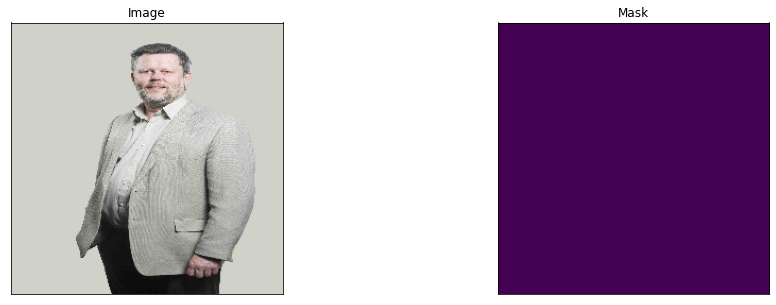

./train/0000fe7c9191fba733c8a69cfaf962b7.jpg
1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


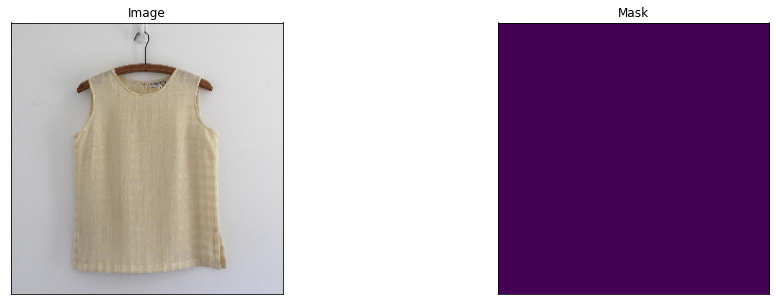

./train/0002ec21ddb8477e98b2cbb87ea2e269.jpg
2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


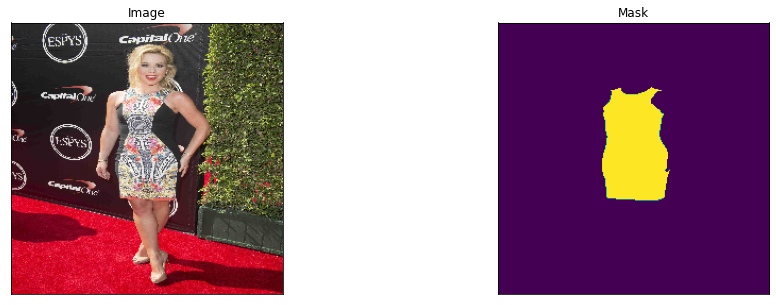

./train/0002f5a0ebc162ecfb73e2c91e3b8f62.jpg
3
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


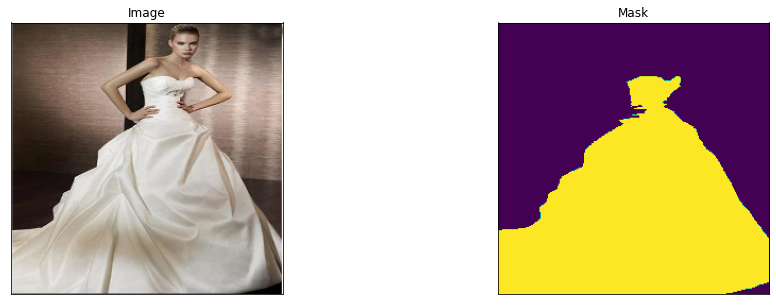

./train/0004467156e47b0eb6de4aa6479cbd15.jpg
4
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


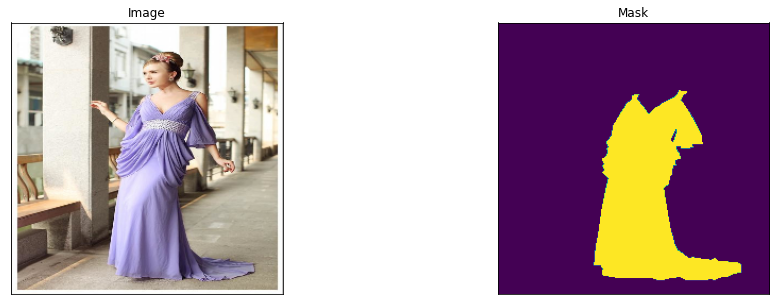

./train/00048c3a2fb9c29340473c4cfc06424a.jpg
5
[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


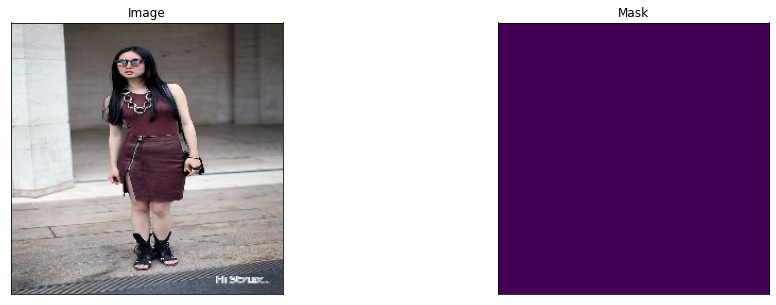

In [50]:
# helper function for data visualization
def visualize(**images):

    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


for i in range(6):
    image, mask, labels = train_dataset[i]
    print(labels)
    mask = mask.squeeze()
    visualize(image=image, mask=mask[:,:,10])

In [ ]:
import shutil
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from iglovikov_helper_functions.utils.mask_utils import rle2mask


output_image_folder = "./images_top"
output_label_folder = "./labels_top"

df = pd.read_csv(df_path_train)
df['CategoryId'] = df.ClassId.apply(lambda x: str(x).split("_")[0])
df = df[df['CategoryId'].isin(['0','1','2','4','3','9','28','31','32','27','10','5','11','29','33','35','36','16'])]

for file_name, dft in tqdm(df.groupby("ImageId")):
    height = dft.iloc[0]["Height"]
    width = dft.iloc[0]["Width"]
    size = Image.open( root_path_train +"/"+ file_name).size

    if (width, height) != size:
        continue

    mask = np.zeros((height, width), dtype=np.uint8)

    for i in dft.index:
        seg = dft.loc[i, "EncodedPixels"]

        mask = mask | rle2mask(seg, (width, height))

    if mask.sum() == 0:
        continue

    shutil.copy(str(root_path_train +"/"+ file_name), str(output_image_folder +"/"+ file_name))
    cv2.imwrite(str(output_label_folder +"/"+ f"{Path(file_name).stem}.jpg"), mask * 255)